## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [7]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

#me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [8]:
# lets go for B2T2 (so 5 DoF)
p = mf.ModelParameters.DynamicModel(2)

## Create some global parameters
p.c = mf.ModelSymbol(value = 0.067,string = 'c') # chord of wing
p.L_1 = mf.ModelSymbol(value = 12,string = 'L_1')
p.L_2 = mf.ModelSymbol(value = 12,string = 'L_2')
p.m_1 = mf.ModelSymbol(value = 12,string = 'm_1')
p.m_2 = mf.ModelSymbol(value = 12,string = 'm_2') 
p.I_xx1 = mf.ModelSymbol(value = 12,string = 'I_xx1')
p.I_xx2 = mf.ModelSymbol(value = 12,string = 'I_xx2') 

p.Lambda = mf.ModelSymbol(value = np.deg2rad(10),string = 'Lambda') # Flare Angle

# Symbols to translate along inner wing and FWT
p.y_2 = sym.Symbol('y_2') # inner wing y chord
p.x_2 = sym.Symbol('x_2') # inner wing x chord
p.y_1 = sym.Symbol('y_1') # FWT y chord
p.x_1 = sym.Symbol('x_1') # FWT x chord

## Aero Parameters
p.rho = mf.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = mf.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA

## Main Wing Specific
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0')               # C_L slope of main wing

## FWT Specific
p.a_1 = p.a_0 - p.a_0/p.L_1*p.y_1                                    # C_L slope of FWT
p.alpha_1 = mf.ModelSymbol(value = 0,string = 'alpha_1')             # FWT alpha
#p.alphadot_1 = mf.ModelSymbol(value = 0,string = 'alphadot_1')       # FWT alphadot

## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point

In [9]:
#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().R_x(p.q[0])
wing_frame = wing_root_frame.Translate(0,p.y_1,0)
wing_com_frame = wing_root_frame.Translate(0,p.L_1/2,0)
fwt_frame = wing_root_frame.Translate(0,p.L_1,0).R_x(p.q[1]).Translate(0,p.y_2,0)
fwt_com_frame = wing_root_frame.Translate(0,p.L_1,0).R_x(p.q[1]).Translate(0,p.L_2/2,0)


#### Create Transforms

In [10]:
#Create Elemnts

M_inner = ele.MassMatrix(p.m_1,I_xx = p.I_xx1)
M_fwt = ele.MassMatrix(p.m_2,I_xx = p.I_xx2)

m_ele = ele.RigidElement(wing_com_frame,M_inner,True)
fwt_ele = ele.RigidElement(fwt_com_frame,M_fwt,True)

# Create AeroForces
wing_AeroForces = ef.AeroForce_1.PerUnitSpan(p,wing_frame,p.a_0,
                               alphadot = 0,
                               M_thetadot = 0,
                               e = 0,
                               rootAlpha = p.alpha_r,
                               deltaAlpha = 0,
                               alpha_zero = 0).integrate((p.y_1,0,p.L_1))

alpha_fwt =  p.alpha_1

fwt_AeroForces_perUnit = ef.AeroForce_1.PerUnitSpan(p,fwt_frame,p.a_1,
                               alphadot = 0,
                               M_thetadot = 0,
                               e = 0,
                               rootAlpha = alpha_fwt,
                                deltaAlpha = 0, 
                               alpha_zero = 0).integrate((p.y_2,0,p.L_2))

# Setup AoA of FWT
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda,p.q[-1])

## Sub in Aero Forces
fwt_AeroForces_perUnit = fwt_AeroForces_perUnit.subs({p.alpha_1:fwt_aoa})

In [11]:
#Create Composite force
CompositeForce = ef.CompositeForce([wing_AeroForces,fwt_AeroForces_perUnit])
# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[m_ele,fwt_ele],CompositeForce)

In [12]:
M = sym.simplify(sm.subs({f:0 for f in p.fp}).M)
M

⎡                2                                    2                       
⎢              L₁ ⋅m₁     2                         L₂ ⋅m₂         L₁⋅L₂⋅m₂⋅co
⎢Iₓₓ₁ + Iₓₓ₂ + ────── + L₁ ⋅m₂ + L₁⋅L₂⋅m₂⋅cos(q₁) + ──────  Iₓₓ₂ + ───────────
⎢                4                                    4                   2   
⎢                                                                             
⎢                                        2                                    
⎢                   L₁⋅L₂⋅m₂⋅cos(q₁)   L₂ ⋅m₂                               L₂
⎢            Iₓₓ₂ + ──────────────── + ──────                        Iₓₓ₂ + ──
⎣                          2             4                                    

          2   ⎤
s(q₁)   L₂ ⋅m₂⎥
───── + ──────⎥
          4   ⎥
              ⎥
2             ⎥
 ⋅m₂          ⎥
────          ⎥
4             ⎦

In [13]:
sm_mini = sm.subs({p.I_xx1:p.m_1*p.L_1**2*12,p.I_xx2:p.m_2*p.L_2**2*12})

In [14]:
sm_mini.M

⎡     2                                       2                             2 
⎢49⋅L₁ ⋅m₁     2                         49⋅L₂ ⋅m₂  L₁⋅L₂⋅m₂⋅cos(q₁)   49⋅L₂ ⋅
⎢───────── + L₁ ⋅m₂ + L₁⋅L₂⋅m₂⋅cos(q₁) + ─────────  ──────────────── + ───────
⎢    4                                       4             2               4  
⎢                                                                             
⎢                                  2                              2           
⎢          L₁⋅L₂⋅m₂⋅cos(q₁)   49⋅L₂ ⋅m₂                      49⋅L₂ ⋅m₂        
⎢          ──────────────── + ─────────                      ─────────        
⎣                 2               4                              4            

  ⎤
m₂⎥
──⎥
  ⎥
  ⎥
  ⎥
  ⎥
  ⎥
  ⎦

In [15]:
sym.cse((sm_mini.M*p.qdd+sm_mini.f))


sym.cse(p.q[0]+p.q[0]*p.qd[0])

⎛            ⎡   d          ⎤⎞
⎜[(x₀, q₀)], ⎢x₀⋅──(x₀) + x₀⎥⎟
⎝            ⎣   dt         ⎦⎠

In [16]:
f = sym.simplify(sm.subs({f:0 for f in p.fp}).f)
f

⎡                                             2                               
⎢                          L₁⋅L₂⋅m₂⋅sin(q₁)⋅q₁̇    L₁⋅g⋅m₁⋅cos(q₀)   g⋅m₂⋅(2⋅L
⎢-L₁⋅L₂⋅m₂⋅sin(q₁)⋅q₀̇⋅q₁̇ - ──────────────────── + ─────────────── + ────────
⎢                                   2                    2                    
⎢                                                                             
⎢                                      ⎛             2                 ⎞      
⎢                                L₂⋅m₂⋅⎝L₁⋅sin(q₁)⋅q₀̇  + g⋅cos(q₀ + q₁)⎠     
⎢                                ───────────────────────────────────────      
⎣                                                   2                         

                           ⎤
₁⋅cos(q₀) + L₂⋅cos(q₀ + q₁))⎥
─────────────────────────────⎥
        2                  ⎥
                           ⎥
                           ⎥
                            ⎥
                           ⎥
                           ⎦

In [30]:
A = sym.Matrix(sym.symbols('a_1,a_2'))
V = sym.Matrix(sym.symbols('v_1,v_2'))
P = sym.Matrix(sym.symbols('p_1,p_2'))
sm_print = sm_mini.subs({p.qd[i]:V[i] for i in [0,1]}).subs({p.q[i]:P[i] for i in [0,1]})
sym.print_python(sm_print.M*A + sm_print.f)

L_1 = Symbol('L_1')
L_2 = Symbol('L_2')
m_2 = Symbol('m_2')
v_1 = Symbol('v_1')
v_2 = Symbol('v_2')
p_2 = Symbol('p_2')
g = Symbol('g')
m_1 = Symbol('m_1')
p_1 = Symbol('p_1')
a_1 = Symbol('a_1')
a_2 = Symbol('a_2')
e = ImmutableDenseMatrix([[-L_1*L_2*m_2*v_1*v_2*sin(p_2) - L_1*L_2*m_2*v_2**2*sin(p_2)/2 + L_1*g*m_1*cos(p_1)/2 - g*m_2*(-L_1*cos(p_1) - L_2*(-sin(p_1)*sin(p_2)/2 + cos(p_1)*cos(p_2)/2)) + a_1*(49*L_1**2*m_1/4 + L_1**2*m_2 + L_1*L_2*m_2*cos(p_2) + 49*L_2**2*m_2/4) + a_2*(L_1*L_2*m_2*cos(p_2)/2 + 49*L_2**2*m_2/4)], [L_1*L_2*m_2*v_1**2*sin(p_2)/2 + 49*L_2**2*m_2*a_2/4 + L_2*g*m_2*(-sin(p_1)*sin(p_2)/2 + cos(p_1)*cos(p_2)/2) + a_1*(L_1*L_2*m_2*cos(p_2)/2 + 49*L_2**2*m_2/4)]])


In [18]:
sym.simplify(sm.linearise(p).subs({f:0 for f in p.fp}).M)

⎡                2                            2                         2   ⎤
⎢              L₁ ⋅m₁     2                 L₂ ⋅m₂         L₁⋅L₂⋅m₂   L₂ ⋅m₂⎥
⎢Iₓₓ₁ + Iₓₓ₂ + ────── + L₁ ⋅m₂ + L₁⋅L₂⋅m₂ + ──────  Iₓₓ₂ + ──────── + ──────⎥
⎢                4                            4               2         4   ⎥
⎢                                                                           ⎥
⎢                                2                                2         ⎥
⎢                   L₁⋅L₂⋅m₂   L₂ ⋅m₂                           L₂ ⋅m₂      ⎥
⎢            Iₓₓ₂ + ──────── + ──────                    Iₓₓ₂ + ──────      ⎥
⎣                      2         4                                4         ⎦

In [19]:
sym.simplify(sm.linearise(p).subs({f:0 for f in p.fp[::2]}).f)

⎡                                2                                 ⎤
⎢                     L₁⋅L₂⋅m₂⋅q̃₃ ⋅q₁   L₁⋅g⋅m₁             L₂⋅g⋅m₂⎥
⎢-L₁⋅L₂⋅m₂⋅q̃₁⋅q̃₃⋅q₁ - ─────────────── + ─────── + L₁⋅g⋅m₂ + ───────⎥
⎢                            2             2                   2   ⎥
⎢                                                                  ⎥
⎢                            ⎛     2       ⎞                       ⎥
⎢                      L₂⋅m₂⋅⎝L₁⋅q̃₁ ⋅q₁ + g⎠                       ⎥
⎢                      ─────────────────────                       ⎥
⎣                                2                                 ⎦

## Create the linearised EoM about some Stationary point

In [28]:
ignores = [p.V,p.m_factor,p.alpha_r,p.ratio_fwt,p.Lambda]

# get the linearised sm
sm_lin = sm.subs(p.GetSubs(0,p.fp,ignore=ignores)).linearise(p)

# get eigen Matrices and turn into a function
K,M = sm_lin.GeneralEigenProblem(p)
K_free,M_free= sm_lin.FreeBodyEigenProblem(p)

gen_func = sym.lambdify((ignores+[p.fp]),(K,M),'numpy')
free_func = sym.lambdify((ignores+[p.fp]),(K_free,M_free),'numpy')

In [29]:
f = (sm.f-sm.ExtForces.Q()).subs({i:0 for i in p.qd}).subs(p.GetSubs(0,[0]*p.qs*2,ignore=ignores))
func_obj = sym.lambdify((p.q,ignores),f)
func_jac_obj = sym.lambdify((p.q,ignores),f.jacobian(p.q))

In [30]:
# set fixed variables
p.ratio_fwt.value = 0.1

#create dict of variations
vars_ls =[]
vars_ls.append((p.m_factor,[0.5,1,1.5,2]))
vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
vars_ls.append((p.alpha_r,np.deg2rad([0,5,10])))
vars_ls.append((p.V,np.linspace(0,150,151))) # ensure velocity last so that fixed points iterats up the velocity
#generate fixed points

#create an array of all possible permutations
perms = np.array(np.meshgrid(*[v for k,v in vars_ls ])).T.reshape(-1,len(vars_ls))

#put in pandas array
df = pd.DataFrame(data = perms, columns=[k.name for k,v in vars_ls])
df['q']=list
df = df.sort_values(by=[k.name for k,v in vars_ls]).reset_index()

In [31]:
## Find fixed point for each use case
pLast = [0]*p.qs
pLast[-1] = np.pi/2
for i in range(len(df)):
    
    #set param values
    for k,v in vars_ls:
        k.value = df[k.name].iloc[i]
    
    #set the initial guess (if v=0 set to FWT dropped doen else use previous result)
    if p.V.value == 0:
        q_guess = [0]*p.qs
        q_guess[-1] = np.pi/2
    else:
        q_guess = df.at[i-1,'q'][::2]
    values = tuple([i.value for i in ignores])
    qf = fsolve(lambda q,v: func_obj(q,values)[:,0],q_guess,fprime = func_jac_obj ,factor = 1,args=(values,))
    #print(f'{np.round(q_guess[-1],2)},{np.round(qf[-1],2)},{p.V.value}')
    #save result
    yf = [0]*p.qs*2  
    yf[::2] = qf
    df.at[i,'q'] = yf

/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)


In [32]:
#Calc freqs and dampings
flutdfv2 = pd.DataFrame() 
for i in range(len(df)):
    
    #set param values
    for k,v in vars_ls:
        k.value = df[k.name].iloc[i]

    #q = df.at[i,'q']
    q = [0]*p.qs*2
    
    values = tuple([i.value for i in ignores])
    if p.V.value == 0:
        evals, evecs = eig(*free_func(*values,q))
    else:
        evals, evecs = eig(*gen_func(*values,q))
    jac_dat = mf.ExtractEigenValueData(evals,evecs,sortby='Frequency')
    
    # populate fixed point data
    jac_dat['q'] = list
    for j in range(len(jac_dat)):
        jac_dat.at[j,'q'] = q

    # populate test specific data
    for k,v in vars_ls:
        jac_dat[k.name] = k.value
        

    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)

In [33]:
flutdf = flutdfv2.copy()
flutdf['Damping [%]'] = flutdf['Damping']*-100
flutdf['Coast Angle [Deg]'] = flutdf.apply(lambda row: np.rad2deg(row['q'][-2]),axis=1)
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))
flutdf['FWT Mass [%]'] = pd.Categorical(flutdf['delta_m']*100)
flutdf['Mode'] = flutdf.Mode.astype('category')

In [34]:
flutdf.head(5)

,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,q,delta_m,Lambda,alpha_r,V,Damping [%],Coast Angle [Deg],Flare Angle [Deg],AoA [Deg],FWT Mass [%]
0,0.000000+0.000000j,0.0,0.000000,0.000000,NaN,True,"[0j, 0j, 0j, 0j, 0j, 0j, (1+0j), 0j, 0j, 0j, 0...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.174533,0.0,0.0,NaN,0.0,10.0,0.0,50.0
1,0.000000+0.000000j,0.0,0.000000,0.000000,NaN,True,"[0j, 0j, 0j, 0j, 0j, 0j, (-0.9999586589059027+...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.174533,0.0,0.0,NaN,0.0,10.0,0.0,50.0
2,0.000000+15.135190j,0.0,15.135190,2.408840,6.123234e-17,True,"[0.0012667013598425866j, -6.237213353910612e-0...",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.174533,0.0,0.0,-6.123234e-15,0.0,10.0,0.0,50.0
3,0.000000+48.325128j,0.0,48.325128,7.691183,6.123234e-17,True,"[0.0008331932049988631j, -0.000106549225932951...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.174533,0.0,0.0,-6.123234e-15,0.0,10.0,0.0,50.0
4,0.000000+70.938151j,0.0,70.938151,11.290157,6.123234e-17,True,"[-0.001433093430041131j, 0.0002079108262053818...",4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.174533,0.0,0.0,-6.123234e-15,0.0,10.0,0.0,50.0


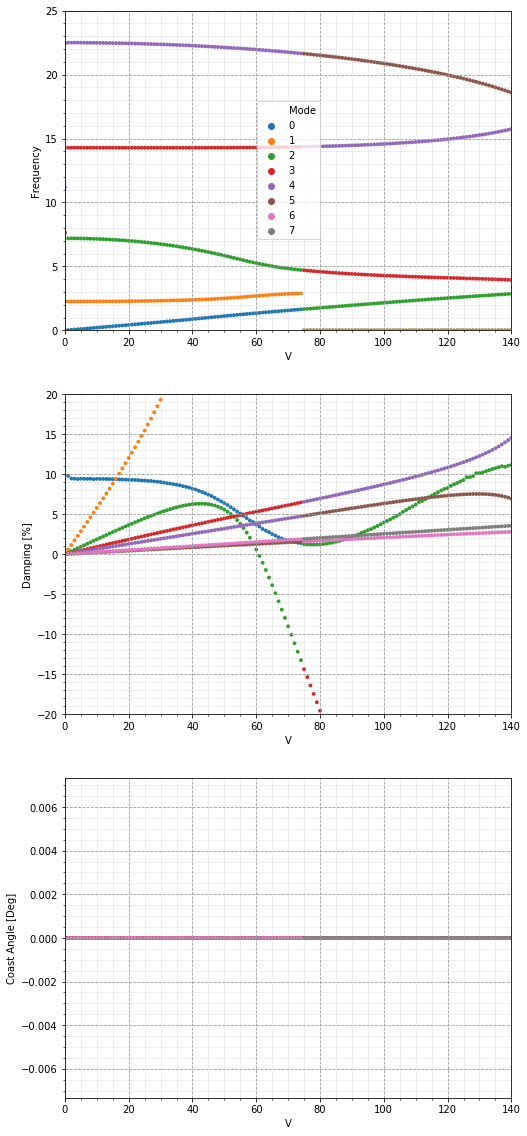

In [35]:
data = flutdf.copy()
data = data[data['Flare Angle [Deg]']==25]
data = data[data['AoA [Deg]']==0]
data = data[data['FWT Mass [%]']==100]
data = data[data['V']<=140]
fig, axes = plt.subplots(3,1,figsize=(8,20))


sns.scatterplot(data=data,x='V',y='Frequency',hue='Mode',ax=axes[0],edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y='Damping [%]',hue='Mode',ax=axes[1],legend=False,edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y='Coast Angle [Deg]',hue='Mode',ax=axes[2],legend=False,edgecolor = 'none',s=15)

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,140))
#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,25))
axes[1].set(ylim=(-20,20))

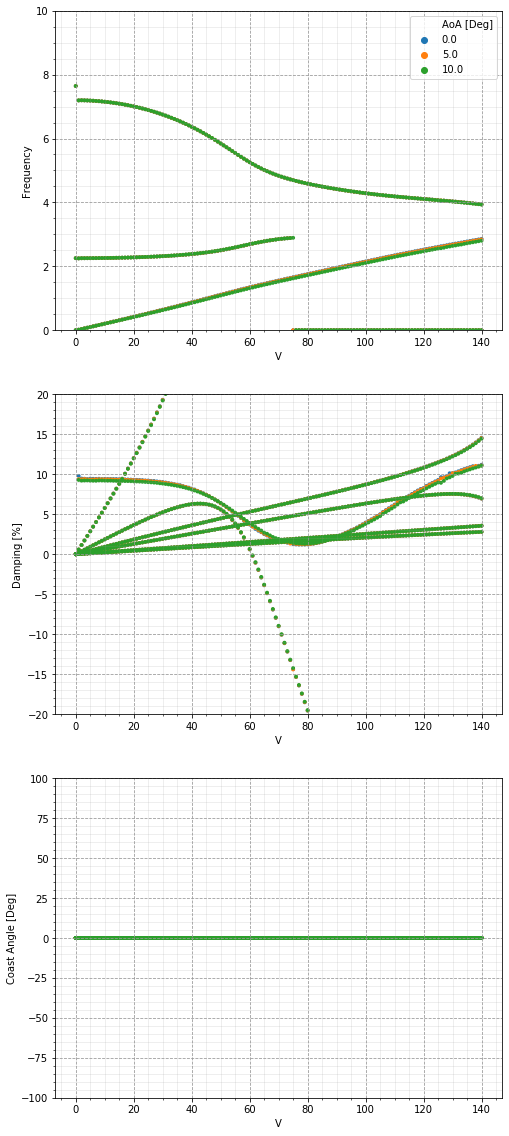

In [36]:
data = flutdf.copy()
data = data[data['V']<=140]
data = data[data['Coast Angle [Deg]']>-100]
data = data[data['Coast Angle [Deg]']<100]
#print(data[['V','q_12']].head(50))
#data = flutdfv2
fig, axes = plt.subplots(3,1,figsize=(8,20))

#huestr = 'AoA [deg]'
#huestr = '$\Lambda$ [deg]'
huestr = 'AoA [Deg]'

data = data[data['Flare Angle [Deg]']==25]
#data = data[data['AoA [Deg]']==np.deg2rad(00)]
data = data[data['FWT Mass [%]']==100]
#data = data[data['m_1']<50]


sns.scatterplot(data=data,x='V',y='Frequency',hue=huestr,ax=axes[0],edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y='Damping [%]',hue=huestr,ax=axes[1],legend=False,edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y=f'Coast Angle [Deg]',hue=huestr,ax=axes[2],legend=False,edgecolor = 'none',s=15)

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,60))
#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,10))
axes[1].set(ylim=(-20,20))
axes[2].set(ylim=(-100,100))

In [20]:
#flutdf.to_pickle('Test_4.pkl')

In [20]:
#pd.read_pickle('Test_3.pkl').head()

,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,q,delta_m,Lambda,alpha_r,V,Damping [%],Coast Angle [Deg],Flare Angle [Deg],AoA [Deg],FWT Mass [%]
0,0.000000+3.132092j,0.000000e+00,3.132092,0.498488,6.123234e-17,False,[(-4.082422735734357e-22+2.7409681841779183e-2...,0,"[-0.001258018093510741, 0, 7.059585261002967e-...",0.5,0.174533,0.0,0.0,-6.123234e-15,90.0,10.0,0.0,50.0
1,0.000000+13.080910j,1.357273e-11,13.080910,2.081892,1.037676e-12,False,[(-1.1513115612390782e-11-0.06593159058972015j...,1,"[-0.001258018093510741, 0, 7.059585261002967e-...",0.5,0.174533,0.0,0.0,-1.037676e-10,90.0,10.0,0.0,50.0
2,0.000000+44.014634j,1.480620e-07,44.014634,7.005147,3.363926e-09,False,[(4.675514109900721e-12+0.00028459502232504823...,2,"[-0.001258018093510741, 0, 7.059585261002967e-...",0.5,0.174533,0.0,0.0,-3.363926e-07,90.0,10.0,0.0,50.0
3,-0.000000+87.742363j,-4.419894e-09,87.742363,13.964631,-5.037342e-11,False,[(1.1720043859013801e-12-0.0057628138900509334...,3,"[-0.001258018093510741, 0, 7.059585261002967e-...",0.5,0.174533,0.0,0.0,5.037342e-09,90.0,10.0,0.0,50.0
4,0.000000+137.164975j,2.039409e-08,137.164975,21.830484,1.486829e-10,False,[(-3.889588646591944e-13-0.0003244578956774234...,4,"[-0.001258018093510741, 0, 7.059585261002967e-...",0.5,0.174533,0.0,0.0,-1.486829e-08,90.0,10.0,0.0,50.0
